In this project, we train a neural network to learn the \textit{Lagrangian} of a physical system -- specifically, a simple pendulum -- directly from motion data. The Lagrangian \( L \) is a function defined as the difference between kinetic and potential energy:

L = T - V

By learning \( L(\theta, \dot{\theta}) \) as a function of the pendulum angle \( \theta \) and angular velocity \( \dot{\theta} \), we can derive the equations of motion using the Euler-Lagrange equation:

\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{\theta}} \right) - \frac{\partial L}{\partial \theta} = 0.


For a pendulum of length \( l \) and gravitational constant \( g \), the true dynamics are given by the second-order ordinary differential equation:


\ddot{\theta} + \frac{g}{l} \sin \theta = 0,


meaning the angular acceleration is:

\ddot{\theta} = -\frac{g}{l} \sin \theta.


Our goal is to have the neural network learn a Lagrangian \( L(\theta, \dot{\theta}) \) such that the Euler-Lagrange equation (computed from the network) produces the correct accelerations.

We simulate pendulum motion to create a dataset of state/velocity/acceleration triplets: \( (\theta, \dot{\theta}, \ddot{\theta}) \). Then, we define a neural network (a multilayer perceptron, or MLP) to represent \( L(\theta, \dot{\theta}) \). During training, for each sample we:


  - Compute the partial derivatives \( \partial L / \partial \theta \) and \( \partial L / \partial \dot{\theta} \) via automatic differentiation (autograd).
  -  Compute the Euler-Lagrange residual or predicted acceleration from those derivatives.
  -Minimize the loss between the network's predicted acceleration and the true acceleration.

By training to satisfy the Euler-Lagrange equations on the data, the network should learn the correct Lagrangian and hence the system dynamics.


In [1]:
import math
import random

# Pendulum parameters and constants
g = 9.81   # gravitational acceleration (m/s^2)
l = 1.0    # pendulum length (m)
dt = 0.05  # time step for simulation (s)

def simulate_pendulum(theta0, omega0, steps=100):
    """Simulate pendulum motion given initial angle theta0 and angular velocity omega0."""
    theta, omega = theta0, omega0
    trajectory = []
    for _ in range(steps):
        # Compute angular acceleration from the pendulum equation: θ¨ = - (g/l) * sin(θ)
        alpha = - (g/l) * math.sin(theta)
        # Record the state and acceleration (θ, θ̇, θ̈)
        trajectory.append((theta, omega, alpha))
        # Update the state using semi-implicit Euler integration
        omega += alpha * dt          # update angular velocity
        theta += omega * dt          # update angle
    return trajectory

# Generate training data from multiple trajectories
train_data = []
initial_conditions = [(1.5, -0.5),  # (initial angle in rad, initial angular velocity in rad/s)
                      (2.0,  0.0),
                      (0.5,  1.0),
                      (-1.0, 0.5)]
for theta0, omega0 in initial_conditions:
    train_data += simulate_pendulum(theta0, omega0, steps=50)

# Shuffle the collected data points
random.shuffle(train_data)
print(f"Generated {len(train_data)} data points from {len(initial_conditions)} trajectories.")
# Each data point is a tuple (theta, theta_dot, theta_ddot)
print("Sample data point:", train_data[0])


Generated 200 data points from 4 trajectories.
Sample data point: (-2.002460403910793, -0.29857564794674246, 8.91013641360569)


In [2]:
import torch

# Convert the training data into PyTorch tensors
train_data_t = torch.tensor(train_data, dtype=torch.float32)
theta_train = train_data_t[:, 0:1]   # θ (angle) column, shape [N, 1]
omega_train = train_data_t[:, 1:2]   # θ̇ (angular velocity) column, shape [N, 1]
alpha_train = train_data_t[:, 2:3]   # θ̈ (angular acceleration) column, shape [N, 1]

# Verify shapes and a sample
print(theta_train.shape, omega_train.shape, alpha_train.shape)
print("First training sample (theta, omega, alpha):", theta_train[0].item(), omega_train[0].item(), alpha_train[0].item())


torch.Size([200, 1]) torch.Size([200, 1]) torch.Size([200, 1])
First training sample (theta, omega, alpha): -2.002460479736328 -0.29857563972473145 8.910136222839355


In [3]:
# Define the Lagrangian Neural Network (a 2-layer MLP)
class LagrangianNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(2, 64),    # input: (theta, omega) -> 64 hidden units
            torch.nn.Softplus(),
            torch.nn.Linear(64, 64),   # second hidden layer
            torch.nn.Softplus(),
            torch.nn.Linear(64, 1)     # output a single value L
        )
    def forward(self, theta, omega):
        # Concatenate theta and omega for the MLP input
        x = torch.cat([theta, omega], dim=1)
        return self.model(x)

# Initialize the model and optimizer
model = LagrangianNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [4]:
# Training the model using the Euler-Lagrange consistency loss
epochs = 100
for epoch in range(1, epochs+1):
    # Enable gradient tracking for input tensors
    theta_train.requires_grad = True
    omega_train.requires_grad = True

    # Step 1: Forward pass to get Lagrangian values
    L_pred = model(theta_train, omega_train)           # L_pred is shape [N,1]

    # Step 2: First derivatives w.rt theta and omega
    L_sum = L_pred.sum()  # sum the outputs to conveniently compute batch gradients at once
    dL_dtheta, dL_domega = torch.autograd.grad(L_sum, (theta_train, omega_train), create_graph=True)
    # dL_dtheta and dL_domega are each shape [N,1], containing ∂L/∂θ and ∂L/∂θ̇ for each sample

    # Step 3: Second derivatives (derivatives of dL/domega)
    # We differentiate the sum of dL/domega values to get second-order terms
    d2L_dtheta2, d2L_domega2 = torch.autograd.grad(dL_domega.sum(), (theta_train, omega_train), create_graph=True)
    # d2L_dtheta2 = ∂(∂L/∂ω)/∂θ (mixed second derivative), d2L_domega2 = ∂(∂L/∂ω)/∂ω (second derivative w.rt ω)

    # Step 4: Compute predicted acceleration from Euler-Lagrange formula
    # Avoid division by zero by adding a small epsilon to the denominator if necessary (for numerical stability)
    eps = 1e-6
    denom = d2L_domega2 + eps
    alpha_pred = (dL_dtheta - d2L_dtheta2 * omega_train) / denom  # predicted θ̈

    # Step 5: Compute MSE loss between predicted and true accelerations
    loss = torch.mean((alpha_pred - alpha_train)**2)

    # Step 6: Backpropagation and optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print training progress occasionally
    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}: training MSE loss = {loss.item():.6f}")


Epoch   1: training MSE loss = 69.490700
Epoch  20: training MSE loss = 26.297703
Epoch  40: training MSE loss = 3.470654
Epoch  60: training MSE loss = 0.893909
Epoch  80: training MSE loss = 0.694189
Epoch 100: training MSE loss = 0.614037


In [7]:
# Simulate a new pendulum trajectory for testing (not part of training data)
test_traj = simulate_pendulum(theta0=1.0, omega0=0.5, steps=50)
theta_test = torch.tensor([s[0] for s in test_traj], dtype=torch.float32).unsqueeze(1)
omega_test = torch.tensor([s[1] for s in test_traj], dtype=torch.float32).unsqueeze(1)
alpha_true = [s[2] for s in test_traj]  # true accelerations for reference

# Use the trained model to predict accelerations for each state in the test trajectory
theta_test.requires_grad = True
omega_test.requires_grad = True
L_test = model(theta_test, omega_test)
dL_dtheta_test, dL_domega_test = torch.autograd.grad(L_test.sum(), (theta_test, omega_test), create_graph=True)
d2L_dtheta2_test, d2L_domega2_test = torch.autograd.grad(dL_domega_test.sum(), (theta_test, omega_test), create_graph=True)
alpha_pred = (dL_dtheta_test - d2L_dtheta2_test * omega_test) / (d2L_domega2_test + 1e-6)

# Compare actual vs predicted accelerations for a few points
print("\nTest trajectory: Actual vs Predicted accelerations (first 5 time steps)")
for i in range(5):
    print(f"t={i*dt:.2f}s: actual α = {alpha_true[i]:.4f},  predicted α = {alpha_pred[i].item():.4f}")



Test trajectory: Actual vs Predicted accelerations (first 5 time steps)
t=0.00s: actual α = -8.2548,  predicted α = -7.9906
t=0.05s: actual α = -8.2779,  predicted α = -7.9661
t=0.10s: actual α = -8.1908,  predicted α = -7.7838
t=0.15s: actual α = -7.9866,  predicted α = -7.4577
t=0.20s: actual α = -7.6505,  predicted α = -6.9836


In [8]:
# Visualize by simulating the pendulum using the learned model's predictions
theta_sim, omega_sim = 1.0, 0.5  # initial state for simulation
predicted_angles = []
true_angles = []
for t in range(50):
    # true physics update (for reference)
    alpha_true_t = - (g/l) * math.sin(theta_sim)
    true_angles.append(theta_sim)
    # model predicted acceleration
    theta_t = torch.tensor([[theta_sim]], requires_grad=True)
    omega_t = torch.tensor([[omega_sim]], requires_grad=True)
    L_val = model(theta_t, omega_t)
    dL_dtheta_val, dL_domega_val = torch.autograd.grad(L_val, (theta_t, omega_t), create_graph=True)
    d2L_dtheta2_val, d2L_domega2_val = torch.autograd.grad(dL_domega_val, (theta_t, omega_t), create_graph=True)
    alpha_pred_val = (dL_dtheta_val - d2L_dtheta2_val * omega_t) / (d2L_domega2_val + 1e-6)
    alpha_pred_val = alpha_pred_val.item()
    predicted_angles.append(theta_sim)
    # Update state using predicted acceleration
    omega_sim += alpha_pred_val * dt
    theta_sim += omega_sim * dt

# Now 'true_angles' and 'predicted_angles' contain the angles over time.


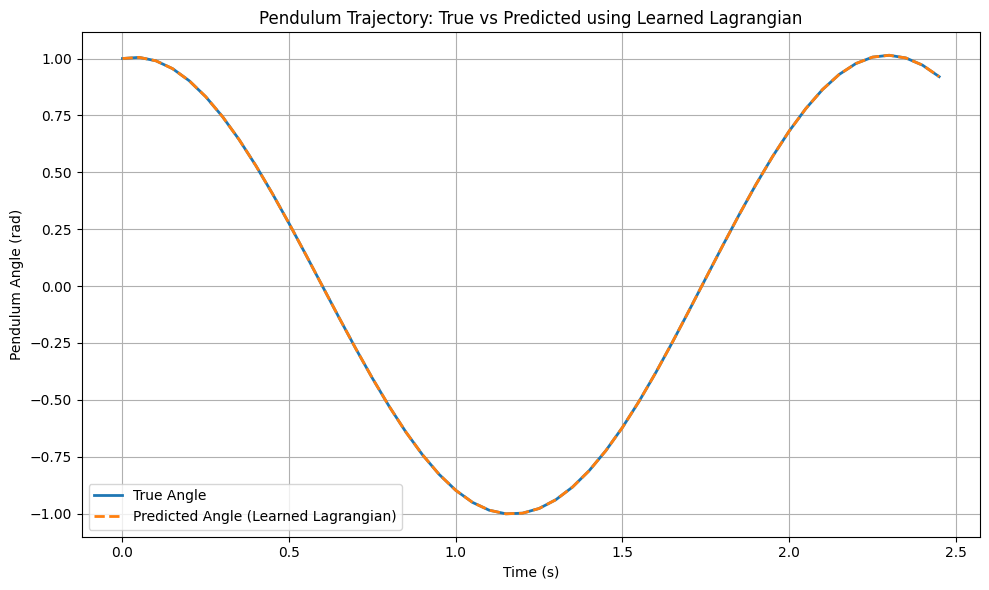

In [9]:
import matplotlib.pyplot as plt

# Generate time steps
time_steps = [i * dt for i in range(len(true_angles))]

# Plot true vs predicted pendulum angles
plt.figure(figsize=(10, 6))
plt.plot(time_steps, true_angles, label='True Angle', linewidth=2)
plt.plot(time_steps, predicted_angles, label='Predicted Angle (Learned Lagrangian)', linestyle='--', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Pendulum Angle (rad)')
plt.title('Pendulum Trajectory: True vs Predicted using Learned Lagrangian')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
